# DPP Env

In [1]:
# %matplotlib inline

# # Rich Traceback is a library that makes tracebacks more readable
# from rich.traceback import install
# install(show_locals=True)

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(2*"../")

from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict.nn import TensorDictModule
from tensordict.tensordict import TensorDict, TensorDictBase
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec, BinaryDiscreteTensorSpec, UnboundedDiscreteTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp


from ncobench.envs.utils import make_composite_from_td, batch_to_scalar, _set_seed

### Making the custom environment

Environment `_step`: this defines the state update of the TSP problem gived a TensorDict (`td` in the code) of the current state and the action to take:

In [3]:
def _step(self, td: TensorDict) -> TensorDict:
    current_node = td["action"]
    first_node = current_node if batch_to_scalar(td["i"]) == 0 else td["first_node"]

    idxs = current_node[...,None] if current_node.ndim == 1 and td["action_mask"].ndim == 2 else current_node

    available = td["action_mask"].scatter(
        -1, idxs.expand_as(td["action_mask"]), 0
    )
    
    # Set done if i is greater than max_decaps
    done = td["i"] >= self.max_decaps
    
    # Calculate reward (minus length of path, since we want to maximize the reward -> minimize the path length)
    # NOTE: reward is calculated outside for now via the get_reward function
    # to calculate here need to pass action sequence or save it as state
    reward = torch.ones_like(done) * float("-inf")

    # The output must be written in a ``"next"`` entry
    return TensorDict(
        {
            "next": {
                "observation": td["observation"],
                "probe": td["probe"],
                "first_node": first_node,
                "current_node": current_node,
                "i": td["i"] + 1,
                "action_mask": available,
                "reward": reward,
                "done": done,
            }
        },
        td.shape,
    )

### Environment Reset
This defines the `_reset` of the TSP. It returns a TensorDict of the initial state:

In [4]:
def _reset(
    self, td: Optional[TensorDict] = None, init_obs=None, batch_size=None
) -> TensorDict:
    # If no tensordict (or observations tensor) is passed, we generate a single set of hyperparameters
    # Otherwise, we assume that the input tensordict contains all the relevant parameters to get started.
    if batch_size is None:
        batch_size = self.batch_size if init_obs is None else init_obs.shape[:-2]
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size
    device = init_obs.device if init_obs is not None else self.device
    self.device = device

    # We allow loading the initial observation from a dataset for faster loading
    if init_obs is None:
        init_obs = self.generate_data(batch_size=batch_size)

    # Other variables
    current_node = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)
    i = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)

    return TensorDict(
        {
            "observation": init_obs["observation"],
            "probe": init_obs["probe"],
            "first_node": current_node,
            "current_node": current_node,
            "i": i,
            "action_mask": init_obs["action_mask"],
        },
        batch_size=batch_size,
    )

### Environment metadata 

This defines the input and output domains of the environment - similar to Gym's `spaces`:

In [5]:
def _make_spec(self):
    """Make the observation and action specs from the parameters"""
    self.observation_spec = CompositeSpec(
        observation=BoundedTensorSpec(
            minimum=self.min_loc,
            maximum=self.max_loc,
            shape=(self.size**2, 2),
            dtype=torch.float32,
        ),
        probe=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        first_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        current_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        action_mask=UnboundedDiscreteTensorSpec(
            # shape=(1, self.size**2),
            shape=(self.size**2),
            dtype=torch.bool
        ),
        shape=(),
    )
    self.input_spec = self.observation_spec.clone()
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        minimum=0,
        maximum=self.size**2,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))
    self.done_spec = UnboundedDiscreteTensorSpec(shape=(1,), dtype=torch.bool)

## Data Generation

In [6]:
def generate_data(self, batch_size):
    # Create a list of observations on a grid
    # n: number of rows and columns
    # num_keepout: number of keepout regions
    # return: a list of observations

    m = n = self.size
    # if int, convert to list and make it a batch for easier generation
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size
    batched = len(batch_size) > 0
    bs = [1] if not batched else batch_size

    # Create a list of observations on a grid
    locs = torch.meshgrid(torch.arange(m, device=self.device), torch.arange(n, device=self.device))
    locs = torch.stack(locs, dim=-1).reshape(-1, 2)
    # normalize the locations by the number of rows and columns
    locs = locs / torch.tensor([m, n], dtype=torch.float, device=self.device)
    locs = locs[None].expand(*bs, -1, -1)

    # Create available mask
    available = torch.ones((*bs, m * n), dtype=torch.bool)

    # Sample probe location from m*n
    probe = torch.randint(m * n, size=(*bs, 1))
    available.scatter_(1, probe, False)

    # Sample keepout locations from m*n except probe
    num_keepout = torch.randint(self.num_keepout_min, self.num_keepout_max, size=(*bs, 1), device=self.device)
    keepouts = [torch.randperm(m * n)[:k] for k in num_keepout]
    for i, (a, k) in enumerate(zip(available, keepouts)):
        available[i] = a.scatter(0, k, False)

    # available = available.unsqueeze(-2)

    return TensorDict(
        {
            "observation": locs if batched else locs.squeeze(0),
            "probe": probe if batched else probe.squeeze(0),
            "action_mask": available if batched else available.squeeze(0),
        },
        batch_size=batch_size,
    )

## Reward function

Sometimes, we want to make it simpler to get the reward outside. Normally, each step should give a reward; but in our case, reward is $-\infty$ unless finished The reason is that normally, we would have to collect all the previous locations and actions _inside_ the environment. But since the model already does that at the end, we can simply call the `get_reward` function to get the reward more efficiently.


In [7]:
def decap_placement(self, pi, probe):
    n = m = self.size # columns and rows
    num_decap = torch.numel(pi)
    z1 = self.raw_pdn
    
    decap = self.decap.reshape(-1)
    z2 = torch.zeros((self.num_freq, num_decap, num_decap), dtype=torch.float32)

    qIndx = torch.arange(num_decap)

    z2[:, qIndx, qIndx] = torch.abs(decap)[:, None].repeat_interleave(z2[:, qIndx, qIndx].shape[-1], dim=-1)
    pIndx = pi.long()

    aIndx = torch.arange(len(z1[0]))
    aIndx = torch.tensor(list(set(aIndx.tolist()) - set(pIndx.tolist())))

    z1aa = z1[:, aIndx, :][:, :, aIndx]
    z1ap = z1[:, aIndx, :][:, :, pIndx]
    z1pa = z1[:, pIndx, :][:, :, aIndx]
    z1pp = z1[:, pIndx, :][:, :, pIndx]
    z2qq = z2[:, qIndx, :][:, :, qIndx]

    zout = z1aa - torch.matmul(torch.matmul(z1ap, torch.inverse(z1pp + z2qq)), z1pa)

    idx = torch.arange(n * m)
    mask = torch.zeros(n * m).bool()
    mask[pi] = True
    mask = mask & (idx < probe)
    probe -= mask.sum().item()

    zout = zout[:, probe, probe]
    return zout

def decap_model(self, z_initial, z_final):
    impedance_gap = torch.zeros(self.num_freq)

    impedance_gap = z_initial - z_final
    reward = torch.sum(impedance_gap * 1000000000 / self.freq)

    reward = reward / 10
    return reward

def initial_impedance(self, probe):
    zout = self.raw_pdn[:, probe, probe]
    return zout

def decap_simulator(self, probe, solution, keepout=None):
    probe = probe.item()

    assert len(solution) == len(torch.unique(solution)), "An Element of Decap Sequence must be Unique"

    if keepout is not None:
        keepout = torch.tensor(keepout)
        intersect = torch.tensor(list(set(solution.tolist()) & set(keepout.tolist())))
        assert len(intersect) == 0, "Decap must be not placed at the keepout region"

    z_initial = self.initial_impedance(probe)
    z_initial = torch.abs(z_initial)
    z_final = self.decap_placement(solution, probe)
    z_final = torch.abs(z_final)
    reward = self.decap_model(z_initial, z_final)

    return reward

def get_reward(self, td, actions):

    # We do the operation in a batch
    if len(td.batch_size) == 0:
        td = td.unsqueeze(0)
        actions = actions.unsqueeze(0)

    probes = td['probe']
    reward = torch.stack([self.decap_simulator(p, a) for p, a in zip(probes, actions)])
    
    return reward

### Environment creation

Here we use `EnvBase` to create the environment similarly to gym:

In [8]:
class DPPEnv(EnvBase):
    batch_locked = False
    name = "dpp"

    def __init__(
        self,
        size: int = 10, # size of the grid (size x size)
        min_loc: float = 0,
        max_loc: float = 1,
        num_freq=201,
        num_keepout_min: int = 1,
        num_keepout_max: int = 50,
        max_decaps: int = 20,
        chip_fpath="data/10x10_pkg_chip.npy", 
        decap_fpath="data/01nF_decap.npy", 
        freq_fpath="data/freq_201.npy",
        td_params: TensorDict = None,
        seed: int = None,
        device: str = "cpu",
    ):
        self.size = size
        self.min_loc = min_loc
        self.max_loc = max_loc
        self.num_freq = num_freq
        self.num_keepout_min = num_keepout_min
        self.num_keepout_max = num_keepout_max
        self.max_decaps = max_decaps

        assert num_keepout_min <= num_keepout_max, "num_keepout_min must be <= num_keepout_max"
        assert num_keepout_max <= size * size, "num_keepout_max must be <= size * size (total number of locations)"

        with open(freq_fpath, "rb") as f:
            self.freq = torch.from_numpy(np.load(f))
        
        with open(chip_fpath, "rb") as f:
            self.raw_pdn = torch.from_numpy(np.load(f))

        with open(decap_fpath, "rb") as f:
            self.decap = torch.from_numpy(np.load(f)).to(torch.complex64)

        super().__init__(device=device, batch_size=[])
        # self._make_spec(td_params)
        self._make_spec()
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    # gen_params = gen_params # we don't use it for this case. See notebook 0
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = _step
    _set_seed = _set_seed

    # Get reward
    get_reward = get_reward

    # Model
    initial_impedance = initial_impedance
    decap_placement = decap_placement
    decap_model = decap_model
    decap_simulator = decap_simulator
    generate_data = generate_data

### Testing the environment

In [9]:
env = DPPEnv(size=10)
check_env_specs(env)

check_env_specs succeeded!


/home/botu/Dev/ncobench/env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
batch_size = 2
td = env.reset(batch_size=batch_size)
for i in range(3):
    td.set("action", torch.tensor([i]).repeat(batch_size))
    print(td['action'].shape)
    td = env.step(td)['next']
    # print("visited2", td['visited'])
    td.set("action", torch.tensor([i]).repeat(batch_size))
    td = env.step(td)['next']

torch.Size([2])
torch.Size([2])
torch.Size([2])


### Plotting

In [11]:
seed = torch.empty((), dtype=torch.int64).random_().item()
print(seed)
env = DPPEnv(size=10, seed=seed)

# Make a rollout
rollout = env.rollout(
    100,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=env.reset(batch_size=[3]),
    break_when_any_done=True
)

# Get the reward afterwards
# observations = rollout['observation'][(rollout_['done'] == 1).squeeze()]
# actions = rollout['action'][(rollout_['done'][:, -1] == 1).squeeze()].squeeze()
# rewards = env.get_reward(observations, actions)
# rollout_finished['reward'][:, -1] = rewards
print(rollout['done'].shape)

1240536731811049673
torch.Size([3, 21, 1])


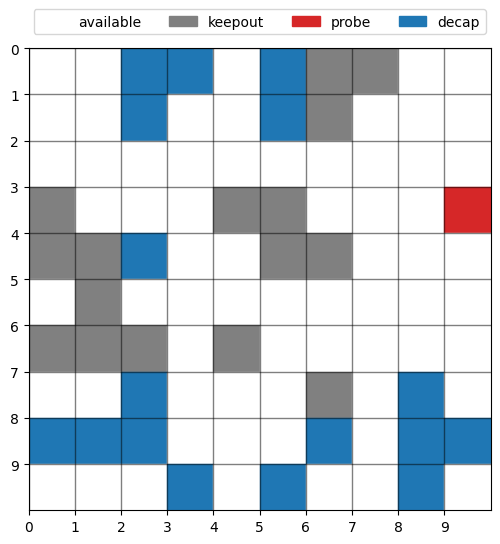

In [14]:
import matplotlib.pyplot as plt

def plot_grid(self, decaps, probe, action_mask, ax=None, legend=True):
    """
    Plot a grid of 1x1 squares representing the environment.
    The keepout regions are the action_mask - decaps - probe
    """
    settings = {
        0: {"color": "white", "label": "available"},
        1: {"color": "grey", "label": "keepout"},
        2: {"color": "tab:red", "label": "probe"},
        3: {"color": "tab:blue", "label": "decap"},
    }

    nonzero_indices = torch.nonzero(~action_mask, as_tuple=True)[0]
    keepout = torch.cat([nonzero_indices, probe, decaps.squeeze(-1)])
    unique_elements, counts = torch.unique(keepout, return_counts=True)
    keepout = unique_elements[counts == 1]

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    grid = np.meshgrid(np.arange(0, self.size), np.arange(0, self.size))
    grid = np.stack(grid, axis=-1)

    # Add new dimension to grid filled up with 0s
    grid = np.concatenate([grid, np.zeros((self.size, self.size, 1))], axis=-1)

    # Add keepout = 1
    grid[keepout // self.size, keepout % self.size, 2] = 1
    # Add probe = 2
    grid[probe // self.size, probe % self.size, 2] = 2
    # Add decaps = 3
    grid[decaps // self.size, decaps % self.size, 2] = 3


    xdim, ydim = grid.shape[0], grid.shape[1]
    ax.imshow(np.zeros((xdim, ydim)), cmap="gray")

    ax.set_xlim(0, xdim)
    ax.set_ylim(0, ydim)

    for i in range(xdim):
        for j in range(ydim):
            color = settings[grid[i, j, 2]]['color']
            x, y = grid[i, j, 0], grid[i, j, 1]
            ax.add_patch(plt.Rectangle((x, y), 1, 1, color=color, linestyle="-"))

    # Add grid with 1x1 squares
    ax.grid(
        which="major", axis="both", linestyle="-", color="k", linewidth=1, alpha=0.5
    )
    # set 10 ticks
    ax.set_xticks(np.arange(0, xdim, 1))
    ax.set_yticks(np.arange(0, ydim, 1))

    # Invert y axis
    ax.invert_yaxis()

    # Add legend
    if legend:
        num_unique = 4
        handles = [
            plt.Rectangle((0, 0), 1, 1, color=settings[i]['color']) for i in range(num_unique)
        ]
        ax.legend(
            handles,
            [settings[i]['label'] for i in range(num_unique)],
            ncol=num_unique,
            loc="upper center",
            bbox_to_anchor=(0.5, 1.1),
        )


td = rollout[-1]

plot_grid(env, td["action"].squeeze(), td["probe"].squeeze(), td["action_mask"][-1])
